In [1]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD,Nadam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, LayerNormalization, LeakyReLU
from tensorflow.keras.optimizers import Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

In [5]:
# Load the data
train = pd.read_csv("/Users/samenergy/Documents/Projects/time series/data/train.csv")
print("Training data shape:", train.shape)
train.head()

Training data shape: (30676, 12)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv,pm2.5
0,1,-1.580878,-1.922250,0.443328,-0.441894,-0.069353,-0.137667,2010-01-01 00:00:00,1.448138,-0.732019,-0.522096,NaN
1,2,-1.580878,-2.004228,0.345943,-0.379306,-0.069353,-0.137667,2010-01-01 01:00:00,1.448138,-0.732019,-0.522096,NaN
2,3,-1.580878,-1.922250,0.248559,-0.343514,-0.069353,-0.137667,2010-01-01 02:00:00,1.448138,-0.732019,-0.522096,NaN
3,4,-1.580878,-2.168183,0.248559,-0.280926,-0.069353,-0.137667,2010-01-01 03:00:00,1.448138,-0.732019,-0.522096,NaN
4,5,-1.511594,-2.004228,0.151174,-0.218339,-0.069353,-0.137667,2010-01-01 04:00:00,1.448138,-0.732019,-0.522096,NaN


In [ ]:
test = pd.read_csv("test.csv")
print("Test data shape:", test.shape)
test.head()

Test data shape: (13148, 11)


,No,DEWP,TEMP,PRES,Iws,Is,Ir,datetime,cbwd_NW,cbwd_SE,cbwd_cv
0,30677,1.190496,0.701029,-2.186052,-0.003982,-0.069353,-0.137667,2013-07-02 04:00:00,1.448138,-0.732019,-0.522096
1,30678,1.121211,0.619051,-2.186052,0.031811,-0.069353,-0.137667,2013-07-02 05:00:00,1.448138,-0.732019,-0.522096
2,30679,1.190496,0.783006,-2.186052,0.094398,-0.069353,-0.137667,2013-07-02 06:00:00,1.448138,-0.732019,-0.522096
3,30680,1.190496,0.946961,-2.088668,0.174782,-0.069353,-0.137667,2013-07-02 07:00:00,1.448138,-0.732019,-0.522096
4,30681,1.190496,1.192893,-1.991283,0.210575,-0.069353,-0.137667,2013-07-02 08:00:00,1.448138,-0.732019,-0.522096


In [6]:
train.columns

Index(['No', 'DEWP', 'TEMP', 'PRES', 'Iws', 'Is', 'Ir', 'datetime', 'cbwd_NW',
       'cbwd_SE', 'cbwd_cv', 'pm2.5'],
      dtype='object')

In [7]:
# Ensure 'datetime' column is in datetime format
train['datetime'] = pd.to_datetime(train['datetime'])

test['datetime'] = pd.to_datetime(test['datetime'])

# Set the 'datetime' column as the index for better time-series handling
train.set_index('datetime', inplace=True)
# val.set_index('datetime', inplace=True)
test.set_index('datetime', inplace=True)

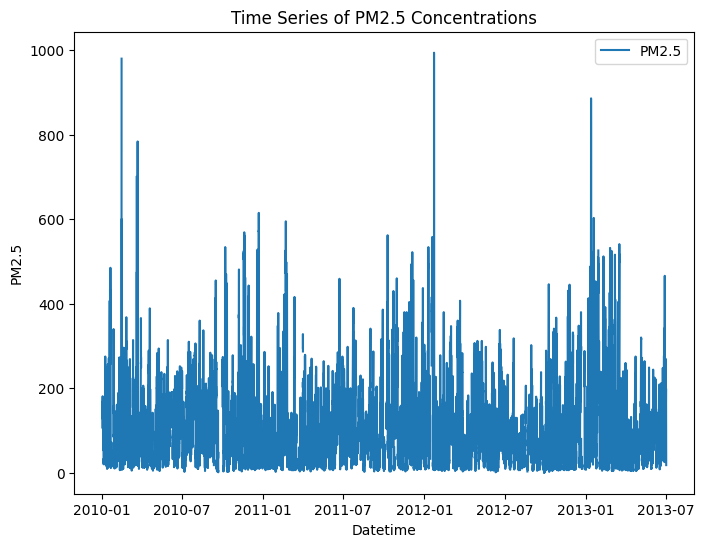

In [8]:
# Visualization: Time series trend for PM2.5
plt.figure(figsize=(8, 6))
# Plot using the DataFrame's index for datetime and access 'pm2.5' from df_train
plt.plot(train.index, train['pm2.5'], label='PM2.5')
plt.title('Time Series of PM2.5 Concentrations')
plt.xlabel('Datetime')
plt.ylabel('PM2.5')
plt.legend()
plt.show()

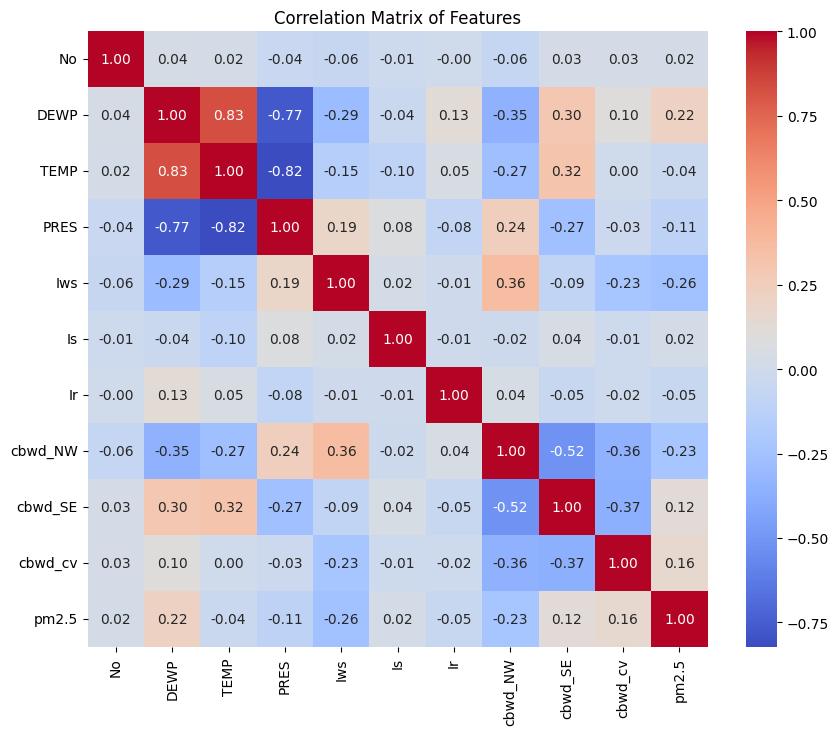

In [9]:
plt.figure(figsize=(10, 8))
# Exclude non-numeric columns before calculating correlations
correlation_matrix = train.select_dtypes(include=['number']).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Features')
plt.show()

In [10]:
# Checking for missing values
print("\nMissing values in training data:")
print(train.isnull().sum())


Missing values in training data:
No            0
DEWP          0
TEMP          0
PRES          0
Iws           0
Is            0
Ir            0
cbwd_NW       0
cbwd_SE       0
cbwd_cv       0
pm2.5      1921
dtype: int64


In [11]:
train.fillna(train.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [12]:
# check if the missining values are fixed
train.isnull().sum()

No         0
DEWP       0
TEMP       0
PRES       0
Iws        0
Is         0
Ir         0
cbwd_NW    0
cbwd_SE    0
cbwd_cv    0
pm2.5      0
dtype: int64

In [13]:
# Prepare features and target
X_train = train.drop(['pm2.5', 'No'], axis=1).to_numpy()
y_train = train['pm2.5'].to_numpy()
X_test = test.drop(['No'], axis=1).to_numpy()

# Scale features and target
feature_scaler = MinMaxScaler()
target_scaler = MinMaxScaler()

X_train_scaled = feature_scaler.fit_transform(X_train)
X_test_scaled = feature_scaler.transform(X_test)
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))

In [14]:
# Define the sequence creation function
seq_length = 48
def create_sequences(data, target, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(target[i+seq_length])
    return np.array(X), np.array(y)

# Create sequences for training
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, seq_length)

In [15]:


# Define the model
model = Sequential([
    Bidirectional(LSTM(64, activation='tanh', return_sequences=True), input_shape=(seq_length, X_train_seq.shape[2])),
    LayerNormalization(),
    Dropout(0.25),
    
    LSTM(32, activation='tanh'),
    LayerNormalization(),
    Dropout(0.25),
    
    Dense(64, kernel_regularizer=l2(0.001)),
    LeakyReLU(alpha=0.1),
    
    Dense(1)
])

/Users/samenergy/Documents/Projects/time series/venv/lib/python3.9/site-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/Users/samenergy/Documents/Projects/time series/venv/lib/python3.9/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [16]:
# Compile the model
model.compile(
    optimizer=Nadam(learning_rate=0.001),
    loss='mean_squared_error',
    metrics=[lambda y, y_pred: tf.sqrt(tf.reduce_mean(tf.square(y - y_pred)))]  # RMSE
)

In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 48, 128)        │        37,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization             │ (None, 48, 128)        │           256 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        20,608 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ layer_normalization_1           │ (None, 32)             │            64 │
│ (LayerNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 60,993 (238.25 KB)

 Trainable params: 60,993 (238.25 KB)

 Non-trainable params: 0 (0.00 B)

In [19]:

# Train the model
history = model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=64,
    validation_split=0.2,
    verbose=1,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)]
)

Epoch 1/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 19ms/step - lambda: 0.1650 - loss: 0.0802 - val_lambda: 0.0765 - val_loss: 0.0355
Epoch 2/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - lambda: 0.0809 - loss: 0.0304 - val_lambda: 0.0700 - val_loss: 0.0230
Epoch 3/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 25ms/step - lambda: 0.0719 - loss: 0.0192 - val_lambda: 0.0731 - val_loss: 0.0170
Epoch 4/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - lambda: 0.0665 - loss: 0.0127 - val_lambda: 0.0695 - val_loss: 0.0124
Epoch 5/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 23ms/step - lambda: 0.0641 - loss: 0.0091 - val_lambda: 0.0671 - val_loss: 0.0096
Epoch 6/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - lambda: 0.0622 - loss: 0.0069 - val_lambda: 0.0656 - val_loss: 0.0082
Epoch 7/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - lambda: 0.0602 - loss: 0.0054 - val_lambda: 0.0653 - val_loss: 0.0071
Epoch 8/50
383/383 ━━━━━━━━━━━━━━━━━━━━ 9s 22ms/step - lambda: 0.0605 - loss: 0.0048 - val_lambda: 0.0664 - val_loss: 0.0066


958/958 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step


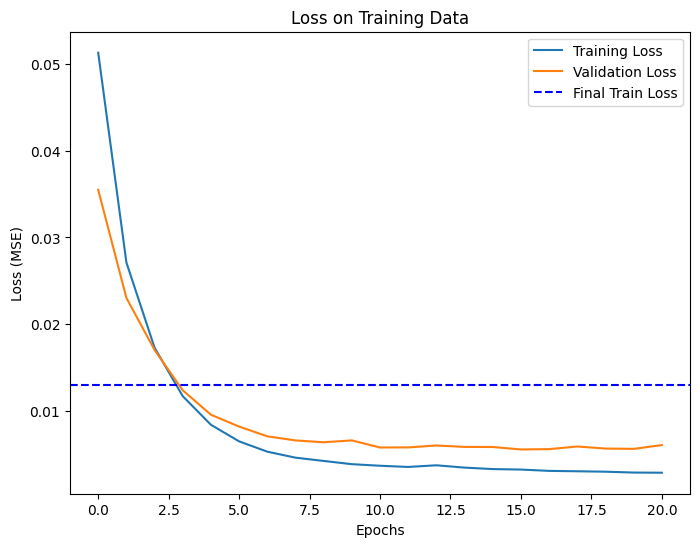

Final Training Loss (MSE): 0.01304064376912473
Final Training RMSE: 0.05851255332161439


In [20]:
train_predictions = model.predict(X_train_seq)
# Reshape train_predictions to match the shape of y_train_seq (30652,)
train_predictions_flat = train_predictions.flatten()

train_loss = np.mean((y_train_seq - train_predictions_flat) ** 2)
train_rmse = np.sqrt(mean_squared_error(y_train_seq, train_predictions_flat))

# Plot training loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')  # Training loss during epochs
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.axhline(y=train_loss, color='blue', linestyle='--', label='Final Train Loss')  # Final training loss
plt.title('Loss on Training Data')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.show()

print(f"Final Training Loss (MSE): {train_loss}")
print(f"Final Training RMSE: {train_rmse}")

In [21]:
# Prepare test sequences without zeros
# Combine the last (seq_length-1) steps of training data with test data
X_combined_scaled = np.vstack((X_train_scaled[-(seq_length-1):], X_test_scaled))
n_test = len(X_test_scaled)

# Create sequences for test set
X_test_seq = []
for i in range(n_test):
    start_idx = i
    end_idx = i + seq_length
    X_test_seq.append(X_combined_scaled[start_idx:end_idx])
X_test_seq = np.array(X_test_seq)

# Verify the shape
print(f"X_test_seq shape: {X_test_seq.shape}")  # Should be (n_test, seq_length, n_features)

# Predict on test set
test_predictions_scaled = model.predict(X_test_seq)
test_predictions = target_scaler.inverse_transform(test_predictions_scaled).flatten()
test_predictions = np.round(test_predictions).astype(int)

# Prepare submission file
submission = pd.DataFrame({
    'row ID': pd.to_datetime(test.index).strftime('%Y-%m-%d %-H:%M:%S'),
    'pm2.5': test_predictions
})

# Save submission file
submission.to_csv('subm_fix001.csv', index=False)
print("Submission file saved successfully!")
print(submission.head())

X_test_seq shape: (13148, 48, 9)
411/411 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Submission file saved successfully!
               row ID  pm2.5
0  2013-07-02 4:00:00     56
1  2013-07-02 5:00:00     57
2  2013-07-02 6:00:00     56
3  2013-07-02 7:00:00     53
4  2013-07-02 8:00:00     48
